In [1]:
import numpy as np 
# import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
def concat_ones(data):
    
    size = len(data)
    new_data = np.concatenate((data, np.ones((size, 1))), axis=1)
    
    return new_data

def prepare_data():
    
    uv = concat_ones(np.load("15_uv.npy"))
    xyz = concat_ones(np.load("15_xyz.npy") * 7)
    img = plt.imread("stereo2012a.jpg")
    origin_and_vanishing_pts = np.load("Vanishing XYZ.npy")

    return uv, xyz, img, origin_and_vanishing_pts

def projection_mse(actual, projected):    
    return np.mean((projected - actual)**2)

In [3]:
def prepare_data():
    
    uv = np.load("15_uv.npy")
    xyz = np.load("15_xyz.npy")
    img = plt.imread("stereo2012a.jpg")
    origin_and_vanishing_pts = np.load("Vanishing XYZ.npy")

    return uv, xyz, img, origin_and_vanishing_pts

In [4]:
def normalize_coordinates(uv, xyz):
    
    scaler_uv = MinMaxScaler()
    scaled_uv = scaler_uv.fit_transform(uv)
    scaled_uv = concat_ones(scaled_uv)

    scaler_xyz = MinMaxScaler()
    scaled_xyz = scaler_xyz.fit_transform(xyz)
    scaled_xyz = concat_ones(scaled_xyz)
    
    return scaled_uv, scaled_xyz, scaler_uv

In [5]:
def get_camera_matrix_dlt(scaled_uv, scaled_xyz):

    equations = []
    b = []
    for i, ele in enumerate(scaled_xyz):

        u = scaled_uv[i, 0]
        v = scaled_uv[i, 1]
        eq1 = np.concatenate((ele, [0,0,0,0], -ele*u))[:-1]
        eq2 = np.concatenate(([0,0,0,0], ele, -ele*v))[:-1]

        equations.append(eq1)
        equations.append(eq2)

        b.append(u)
        b.append(v)


    A, b = np.array(equations), np.array(b)

    C = np.linalg.lstsq(A, b, rcond=None)[0]
    C = np.concatenate((C, [1]))
    C = C.reshape((3,4))
    
    return C

In [6]:
def xyz_to_uv(C, scaled_xyz, scaler_uv):
    
    uv_preds = (C @ scaled_xyz[:,:,None]).reshape((-1,3))
    uv_preds = uv_preds[:,:2] / uv_preds[:,-1, None]

    uv_preds = scaler_uv.inverse_transform(uv_preds)
    
    return uv_preds

In [7]:
def visualise_results(img, uv, origin_and_vanishing_pts, uv_preds):

    # Show images
    fig, ax = plt.subplots(1, 2, figsize=(15,7))

    # Show selected points on input image
    ax[0].imshow(img)
    ax[0].scatter(uv[:,0], uv[:,1], s=5, marker = 'o', c='w')
    ax[0].set_title("Selected points for Calibration")

    # Visualize lines from the origin to the vanishing points in the X, Y and Z direction
    color = 'red' # Line color
    ax[0].plot(origin_and_vanishing_pts[:2,0], origin_and_vanishing_pts[:2,1], c=color)
    ax[0].plot(origin_and_vanishing_pts[1:3,0], origin_and_vanishing_pts[1:3,1], c=color)
    ax[0].plot(origin_and_vanishing_pts[[1,3],0], origin_and_vanishing_pts[[1,3],1], c=color)

    # Show selected points on input image
    ax[1].imshow(img)
    ax[1].scatter(uv[:,0], uv[:,1], s=5, marker = 'o',c='w')
    ax[1].scatter(uv_preds[:,0], uv_preds[:,1], s=2, marker='x', c='b')
    ax[1].set_title("Calibration Results (MSE = {})".format(projection_mse(uv, uv_preds).round(4)))

    plt.show()

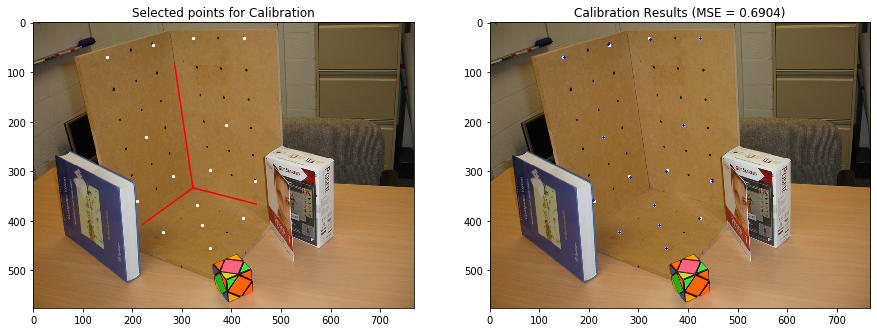

In [8]:
# Read image coordinates (u, v) and real world coordinates (x, y, z)
uv, xyz, img, origin_and_vanishing_pts = prepare_data()

# Normalise all coordinates in the range [0, 1]
scaled_uv, scaled_xyz, scaler_uv = normalize_coordinates(uv, xyz)

# Calculate the Camera Matrix using Direct Linear Transformation (DLT)
C = get_camera_matrix_dlt(scaled_uv, scaled_xyz)

# Project normalised x, y, z coordinates onto image plane 
uv_preds = xyz_to_uv(C, scaled_xyz, scaler_uv)    

# Visualise actual u, v points and projections
visualise_results(img, uv, origin_and_vanishing_pts, uv_preds)

In [16]:
def vgg_rq(S):
    S = S.T
    [Q,U] = np.linalg.qr(S[::-1,::-1], mode='complete')

    Q = Q.T
    Q = Q[::-1, ::-1]
    U = U.T
    U = U[::-1, ::-1]
    if np.linalg.det(Q)<0:
        U[:,0] = -U[:,0]
        Q[0,:] = -Q[0,:]
    return U,Q


def vgg_KR_from_P(P, noscale = True):
    N = P.shape[0]
    H = P[:,0:N]
#     print(N,'|', H)
    [K,R] = vgg_rq(H)
    if noscale:
        K = K / K[N-1,N-1]
        if K[0,0] < 0:
            D = np.diag([-1, -1, np.ones([1,N-2])]);
            K = K @ D
            R = D @ R
        
            test = K*R; 
            assert (test/test[0,0] - H/H[0,0]).all() <= 1e-07
    
    t = np.linalg.inv(-P[:,0:N]) @ P[:,-1]
    return K, R, t

K, R, t = vgg_KR_from_P(C)

In [ ]:
# # Show images
# fig, ax = plt.subplots(1, 2, figsize=(15,7))

# # Show original stereo image
# ax[0].imshow(img)
# ax[0].set_title("Image (stereo2012a) for Camera Calibration")

# # Show selected points on input image
# ax[1].imshow(img)
# ax[1].scatter(uv[:,0], uv[:,1], s=2, c='w')
# ax[1].set_title("Selected points for Calibration")

# # Visualize lines from the origin to the vanishing points in the X, Y and Z direction
# color = 'red' # Line color
# ax[1].plot(origin_and_vanishing_pts[:2,0], origin_and_vanishing_pts[:2,1], c=color)
# ax[1].plot(origin_and_vanishing_pts[1:3,0], origin_and_vanishing_pts[1:3,1], c=color)
# ax[1].plot(origin_and_vanishing_pts[[1,3],0], origin_and_vanishing_pts[[1,3],1], c=color)

# plt.show()